In [1]:
#General Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import os

#Tess CPM Imports
import tess_cpm
import lightkurve as lk
from astropy.io import fits
from astropy.wcs import WCS
from IPython.display import HTML

#TP CPM Imports
import requests
import shutil

#ZTF Imports
import urllib.request, json 
from antares_client.search import search as antares_search
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern

# Notebook to test reduction of a ZTF Transient

Sample Target: SN 2019neq/ZTF19abpbopt  
https://lasair.roe.ac.uk/object/ZTF19abpbopt/  
https://supernova.exchange/view_object?name=2019neq  
pos=(268.611400 +47.261267)  

>## This is in a Chip-Gap!  Too bad.  New Target, boring but bright Ia:

>Sample Target: SN 2019ptv/ZTF19abxfunp 
>https://lasair.roe.ac.uk/object/ZTF19abxfunp/
>pos=(300.289593, 50.860091)

>Swap to 19ust when data becomes available

# THIS IS A FAINT SUPERNOVA, m~19-17!
So lets manage expectations

## First, get the ZTF data from a broker 
Antares to start - it has a decent API and is where the PrestoColor Filter will live  
Start with assuming the user has a know ZTF ID; can branch out to different search options easily enough  
'properties.ztf_programpi': 'TESS' will enforce data from the TESS follow-up program only (i.e.simultaneous coverage)

In [134]:
#ztf_name="ZTF19abpbopt"
ztf_name="ZTF19abxfunp"

In [135]:
antares_query = {
  "query": {
    "wildcard": {
      "properties.ztf_object_id.keyword": ztf_name
    }
  }
}

antares_data= antares_search(antares_query)
#antares_data

# Lets turn this into a ZTF Lightcurve  
Build a minimal dataframe from just what we care about for now

In [136]:
ztf_lc=pd.DataFrame({"mjd":[],
                       "mag":[],
                       "mag_err":[],
                       "mag_lim":[],
                       "band":[]
})

for item in antares_data:
    if 'ztf_magpsf' in item['properties']:
        mag=float(item['properties']['ztf_magpsf'])
    else:
        mag=float('NaN')
    ztf_lc=ztf_lc.append(pd.DataFrame({"mjd":float(item['mjd']),
                                           "mag":mag,
                                           "mag_err":float(item['properties']['ztf_magzpscirms']),
                                           "mag_lim":float(item['properties']['ztf_diffmaglim']),
                                           "band":   item['properties']['passband']
                                          },index=[0]),
                             ignore_index = True)

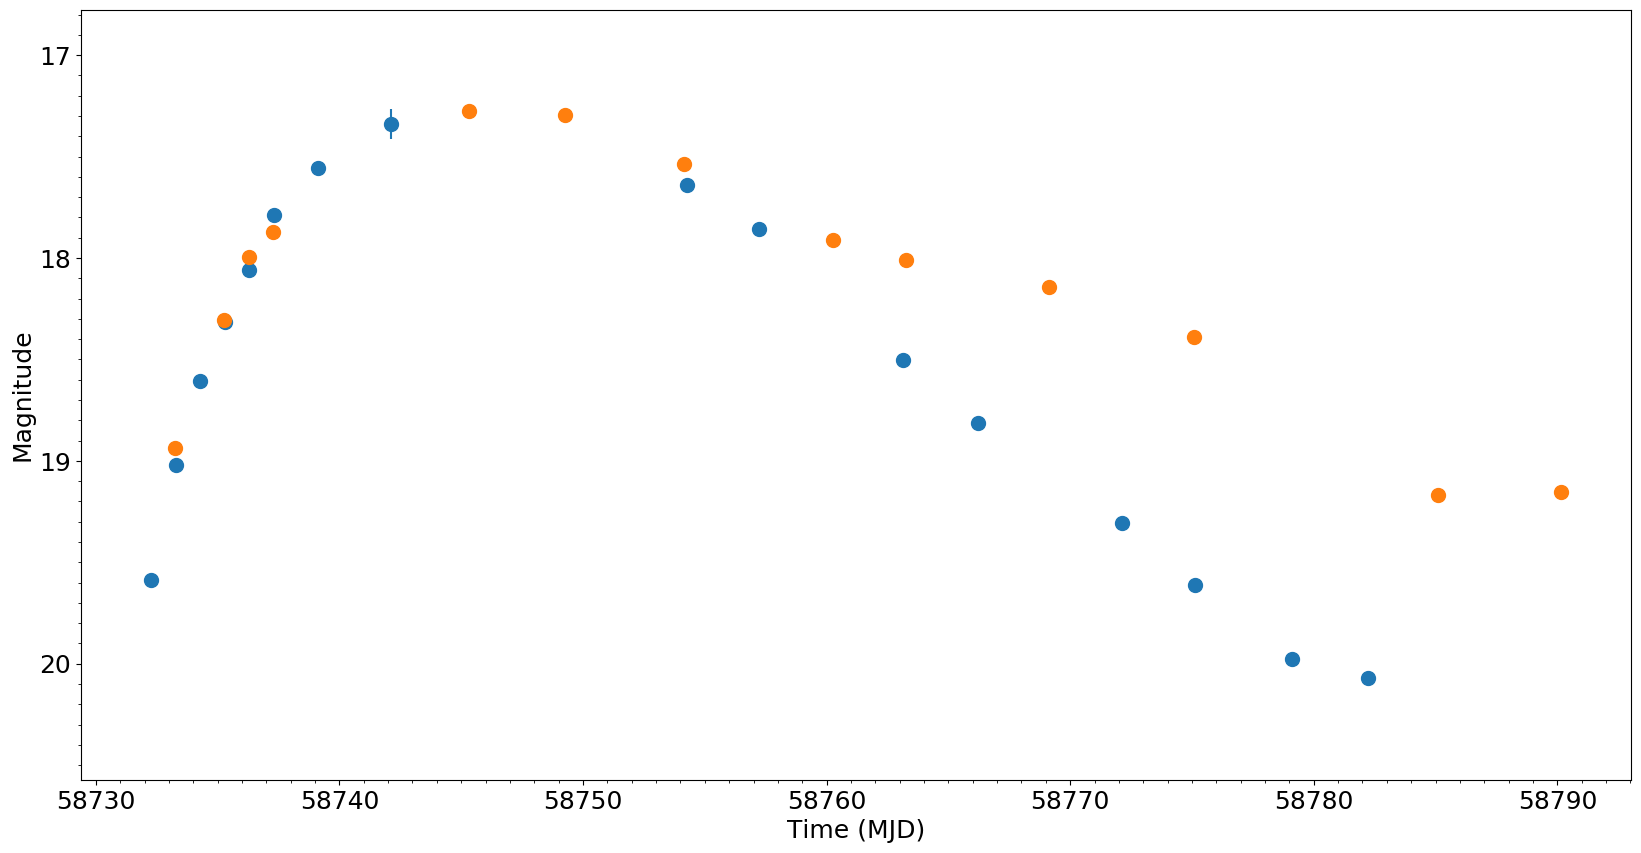

In [137]:
plt.style.use('default')
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(figsize=(20, 10))
ax.errorbar(ztf_lc.loc[(ztf_lc.band == 'g'), 'mjd'],
            ztf_lc.loc[(ztf_lc.band == 'g'), 'mag'],
            ztf_lc.loc[(ztf_lc.band == 'g'), 'mag_err'],
            fmt='o',markersize=10)
ax.errorbar(ztf_lc.loc[(ztf_lc.band == 'R'), 'mjd'],
            ztf_lc.loc[(ztf_lc.band == 'R'), 'mag'],
            ztf_lc.loc[(ztf_lc.band == 'R'), 'mag_err'],
            fmt='o',markersize=10)

ax.set_ylim(np.nanmax(ztf_lc.mag+.5),np.nanmin(ztf_lc.mag-.5))
ax.set_xlabel('Time (MJD)')
ax.set_ylabel('Magnitude')

ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

## Now, Lets do some basic GP interpolation  
We're going to need to re-sample this onto a common grid with the TESS Observations  
Quick & Dirty, this could be done better in detail - should use 2-gp not 2 ind., etc. 

In [138]:
def ztf_gpinterp(mjd,mag):
    time=np.array(mjd).reshape(-1,1)
    val=np.array(mag)
    
    #kernel =1.0*RBF(length_scale=100, length_scale_bounds=(1e-3,1e3)) #\
    #+ WhiteKernel(noise_level=1, noise_level_bounds=(1e-2,1e3))
    
    #kernel = Matern(length_scale=10.0, length_scale_bounds=(1, 100), nu=2.5) \
    kernel =1.0*RBF(length_scale=5, length_scale_bounds=(1,1e2)) \
    + WhiteKernel(noise_level=1)
    
    gp=GaussianProcessRegressor(kernel=kernel, alpha=0.0)
    gp.fit(time, val)
    time_pred=np.linspace(min(time),max(time)).reshape(-1,1)
    val_pred,val_sigma = gp.predict(time_pred, return_std=True)
    return time_pred.reshape(-1), val_pred, val_sigma

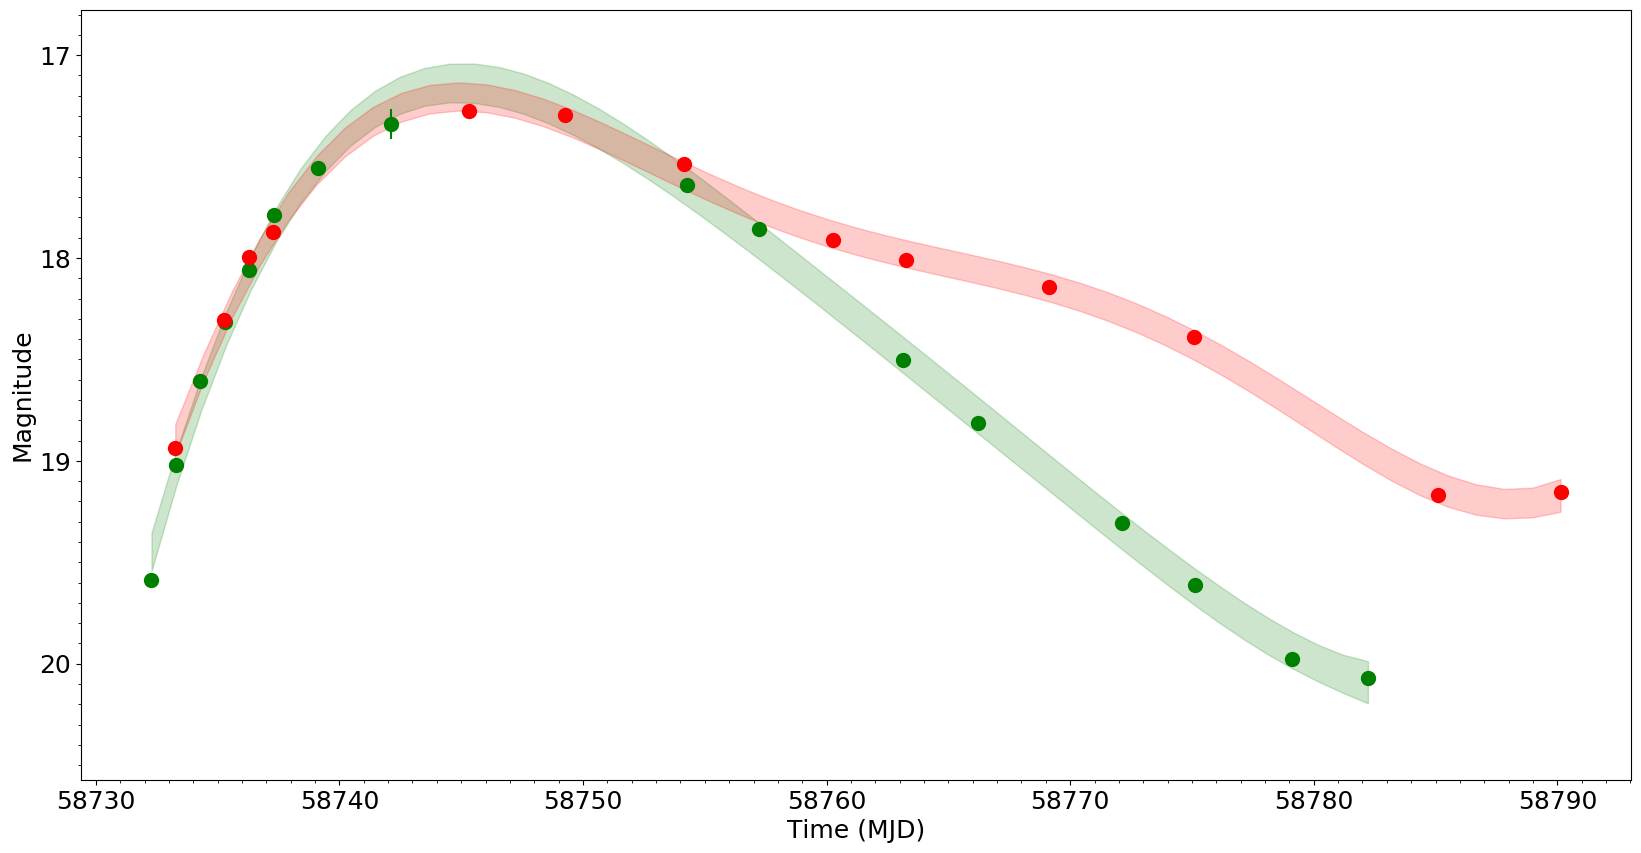

In [139]:
plt.plfig, ax = plt.subplots(figsize=(20, 10))

ax.errorbar(ztf_lc.loc[(ztf_lc.band == 'g'), 'mjd'],
            ztf_lc.loc[(ztf_lc.band == 'g'), 'mag'],
            ztf_lc.loc[(ztf_lc.band == 'g'), 'mag_err'],
            fmt='o',color='g',markersize=10)
ax.errorbar(ztf_lc.loc[(ztf_lc.band == 'R'), 'mjd'],
            ztf_lc.loc[(ztf_lc.band == 'R'), 'mag'],
            ztf_lc.loc[(ztf_lc.band == 'R'), 'mag_err'],
            fmt='o',color='r',markersize=10)

gp_mjd_g, \
gp_mag_g, \
gp_sigma_g = ztf_gpinterp(ztf_lc.loc[(ztf_lc.band == 'g') & (np.invert(np.isnan(ztf_lc.mag))),'mjd'],
                          ztf_lc.loc[(ztf_lc.band == 'g') & (np.invert(np.isnan(ztf_lc.mag))),'mag'])

gp_mjd_r, \
gp_mag_r, \
gp_sigma_r = ztf_gpinterp(ztf_lc.loc[(ztf_lc.band == 'R') & (np.invert(np.isnan(ztf_lc.mag))),'mjd'],
                          ztf_lc.loc[(ztf_lc.band == 'R') & (np.invert(np.isnan(ztf_lc.mag))),'mag'])


ax.fill_between(gp_mjd_g,gp_mag_g-gp_sigma_g,gp_mag_g+gp_sigma_g,color='g',alpha=0.20)

ax.fill_between(gp_mjd_r,gp_mag_r-gp_sigma_r,gp_mag_r+gp_sigma_r,color='r',alpha=0.20)

ax.set_ylim(np.nanmax(ztf_lc.mag+.5),np.nanmin(ztf_lc.mag-.5))
ax.set_xlabel('Time (MJD)')
ax.set_ylabel('Magnitude')

ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

# Start TESS Reduction
Following along from supernovae.ipynb. \
First some plotting config

In [4]:
# These are just some generic plotting configurations
plt.rcParams["figure.figsize"] = (12, 10)
plt.rcParams['animation.html'] = 'jshtml'

## Let's use the ZTF data from Antares to download a TESS cutout from a FFI
From the file in the supernovae notebook it looks like cpm is currently using 100 x 100  
pos is quick and dirty - just taking the first detection; should be turned into median probably and skycoord obj  
this download could be done better; but proof of concept

In [5]:
ztf_pos=(antares_data[0]['ra'],antares_data[0]['dec'])
ztf_tpf=tess_cpm.get_data(ztf_pos[0], ztf_pos[1],size=100) #this is just a helper function for Tesscut
ztf_tpf

Inflating...


In [25]:
ztf_tpf

Local Path
str59
./tess-s0014-2-4_311.054769_39.885048_31x31_astrocut.fits
./tess-s0015-2-3_300.289579_50.860062_100x100_astrocut.fits
./tess-s0016-2-3_300.289579_50.860062_100x100_astrocut.fits


 There is occasionally a server timeout error above - seems to be a MAST issue if it is re-run

## Allright, so use new tpf to run through CPM  
Perhaps this should be optionally kept in memory instead, but the download is a bit annoying . 


In [26]:
fits_files=[ './tess-s0014-2-4_311.054769_39.885048_31x31_astrocut.fits', 
            './tess-s0015-2-3_300.289579_50.860062_100x100_astrocut.fits', 
            './tess-s0016-2-3_300.289579_50.860062_100x100_astrocut.fits']

## Create One New CPM Model for Each Section 
This could be done behind the scenes but are being explicit here and needs more optimization/tuning to be fully automated

In [35]:
sn_s14 = tess_cpm.Source(fits_files[0], remove_bad=True) 
sn_s15 = tess_cpm.Source(fits_files[1], remove_bad=True)
sn_s16 = tess_cpm.Source(fits_files[2], remove_bad=True)

Removing 4 bad data points (out of 1241) using the TESS provided QUALITY array
Removing 7 bad data points (out of 1197) using the TESS provided QUALITY array
Removing 3 bad data points (out of 1121) using the TESS provided QUALITY array


# There is no Real Data in Sector 14; we are using it as a systematics check

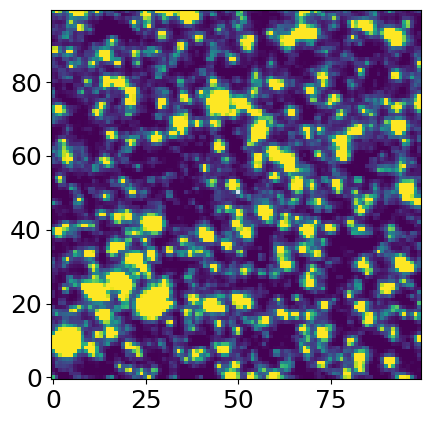

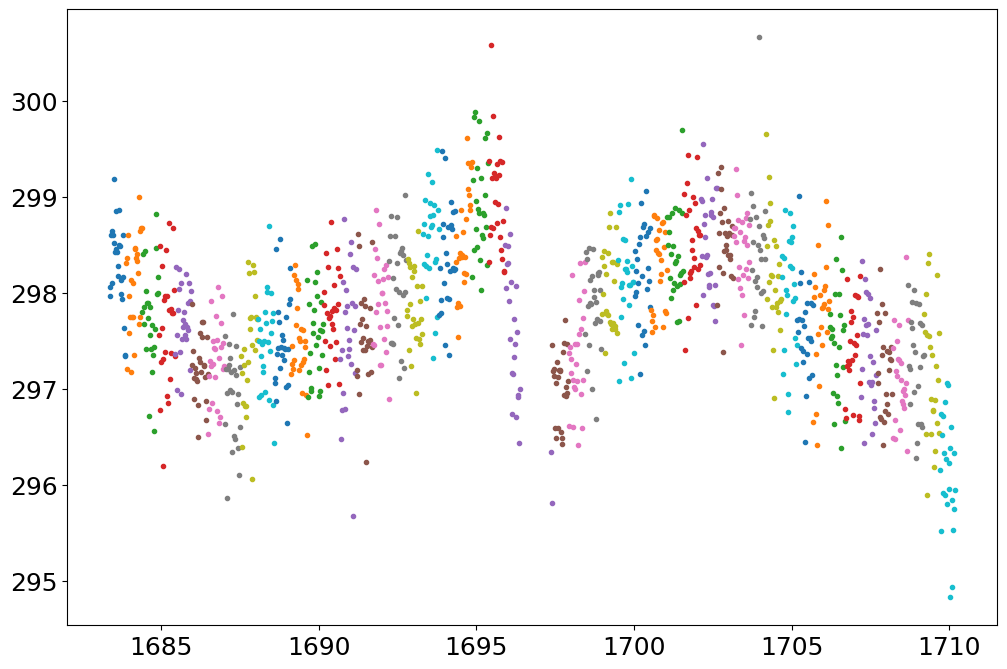

Summing over 1 x 1 pixel lightcurves


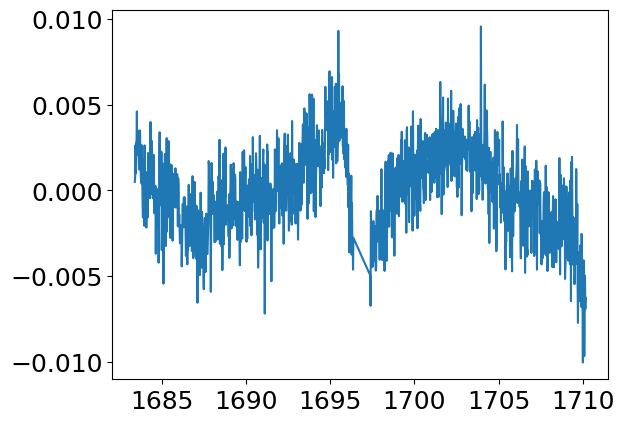

In [133]:
sn_s14.set_aperture(rowrange=[50, 51], colrange=[50,51])
sn_s14.plot_cutout(show_aperture=True)
sn_s14.add_cpm_model()
sn_s14.add_poly_model(num_terms=0)
sn_s14.set_regs([0.01, 0.1])
sn_s14.holdout_fit_predict(k=50);
sn_s14.plot_pix_by_pix("rescaled_cpm_subtracted_flux", split=True)
sn_s14_lc = sn_s14.get_aperture_lc("cpm_subtracted_flux")
plt.plot(sn_s14.time, sn_s14_lc)

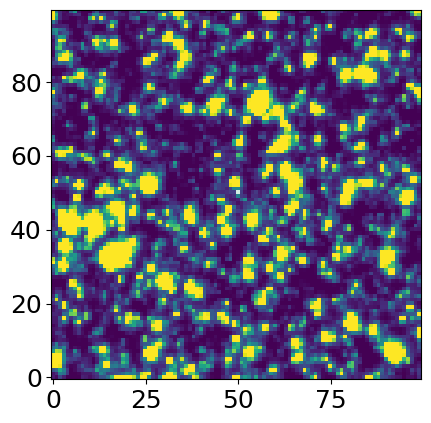

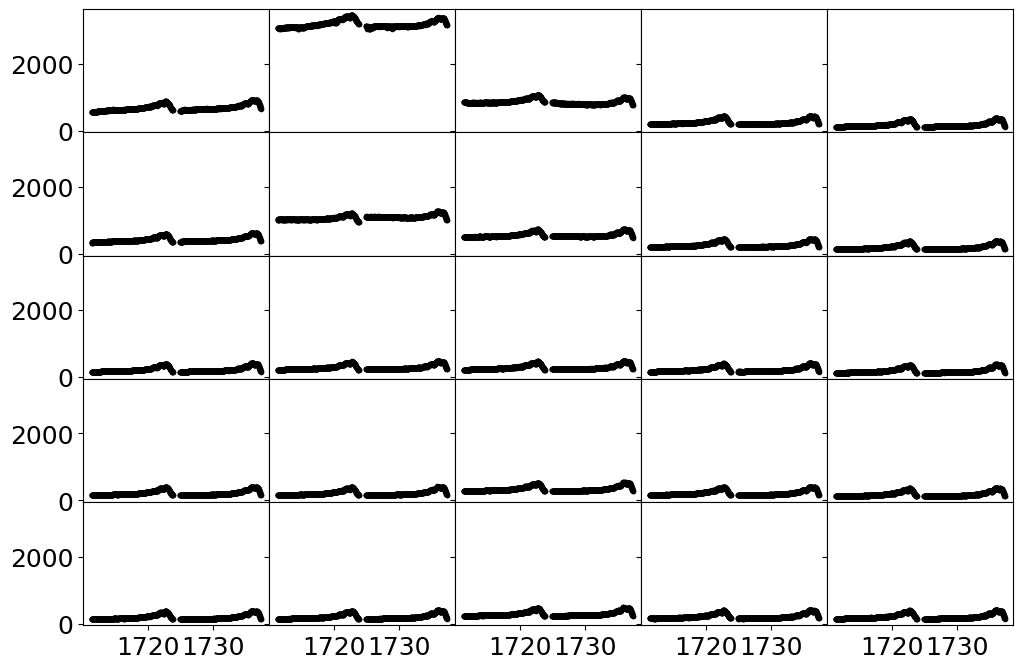

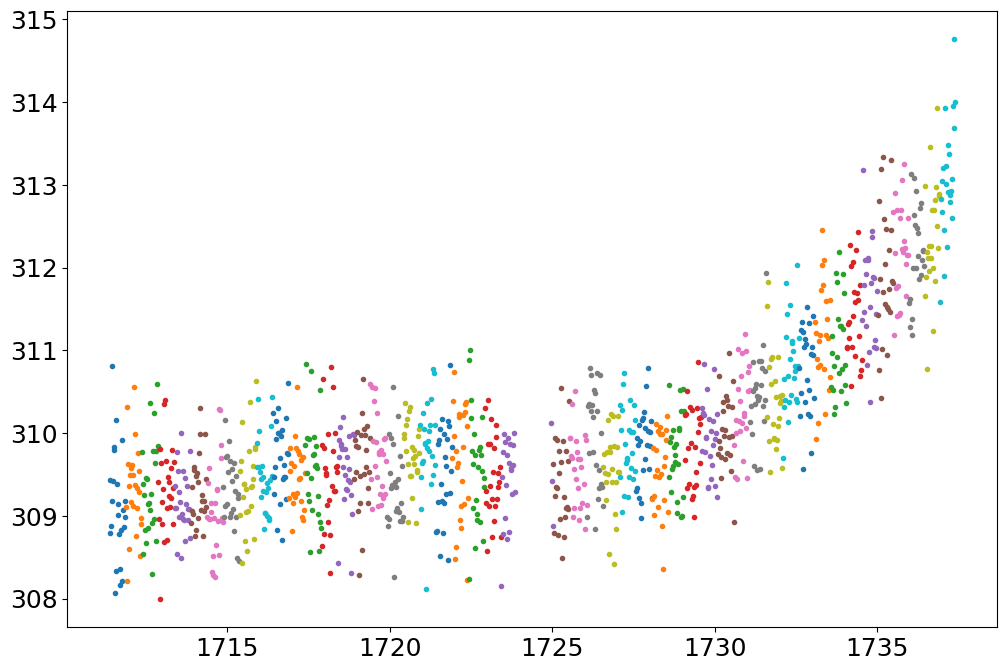

Summing over 1 x 1 pixel lightcurves


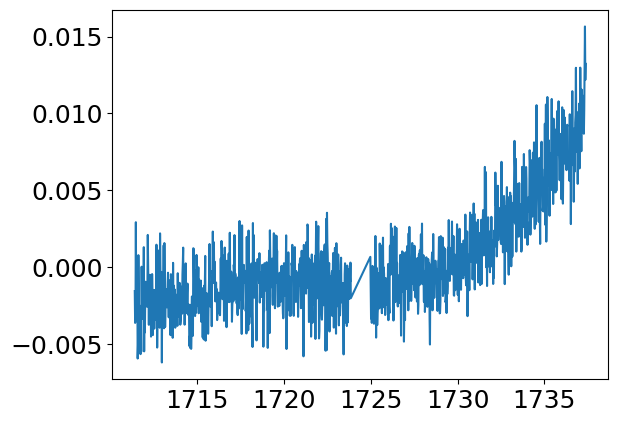

In [107]:
sn_s15.set_aperture(rowrange=[50,51], colrange=[50,51])
sn_s15.plot_cutout(show_aperture=True)
sn.plot_pix_by_pix(data_type="raw")
sn_s15.add_cpm_model()
sn_s15.add_poly_model()
sn_s15.set_regs([0.01, 0.1])
sn_s15.holdout_fit_predict(k=50);
sn_s15.plot_pix_by_pix("rescaled_cpm_subtracted_flux", split=True)
sn_s15_lc = sn_s15.get_aperture_lc("cpm_subtracted_flux")
plt.plot(sn_s15.time, sn_s15_lc)

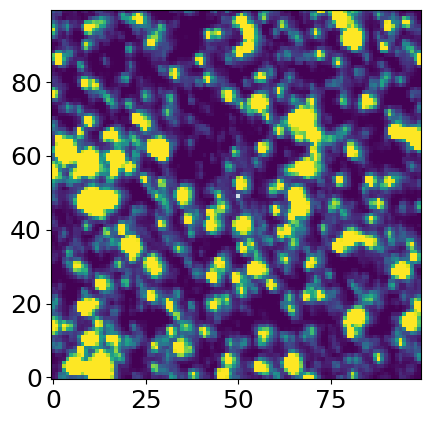

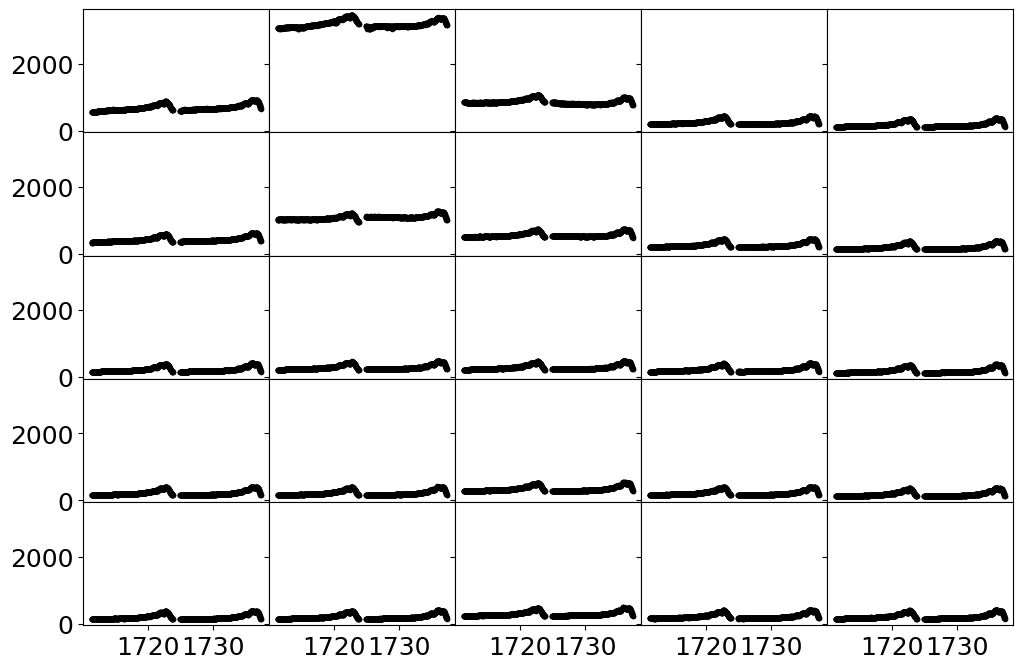

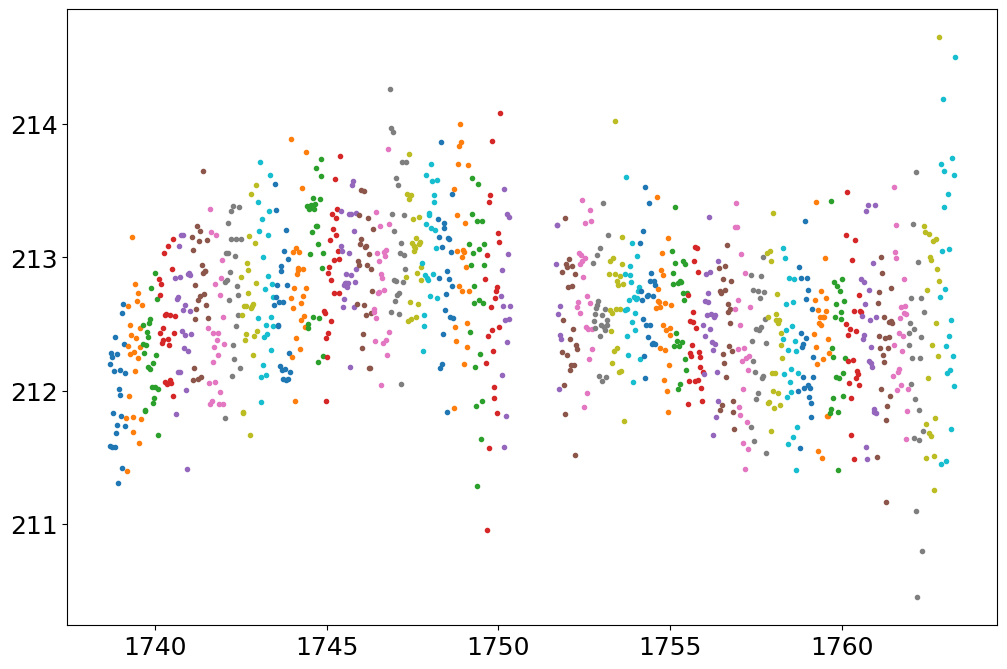

Summing over 1 x 1 pixel lightcurves


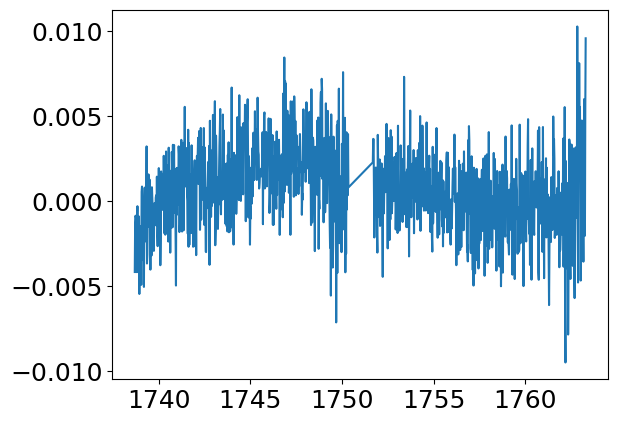

In [126]:
sn_s16.set_aperture(rowrange=[49,50], colrange=[50,51])#49-51 ok
sn_s16.plot_cutout(show_aperture=True)
sn.plot_pix_by_pix(data_type="raw")
sn_s16.add_cpm_model()
sn_s16.add_poly_model()
sn_s16.set_regs([0.01, 0.1])
sn_s16.holdout_fit_predict(k=50);
sn_s16.plot_pix_by_pix("rescaled_cpm_subtracted_flux", split=True)
sn_s16_lc = sn_s16.get_aperture_lc("cpm_subtracted_flux")
plt.plot(sn_s16.time, sn_s16_lc)

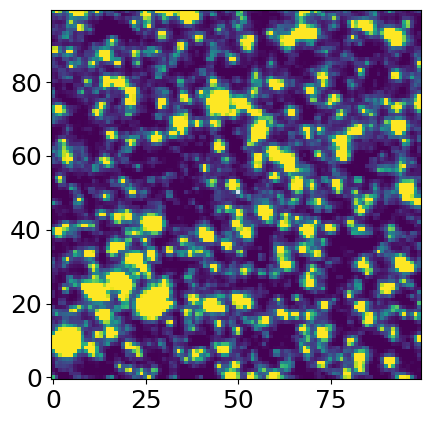

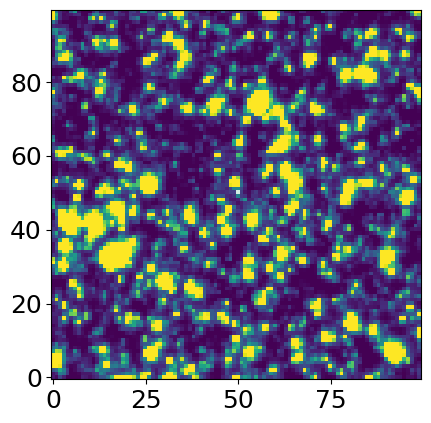

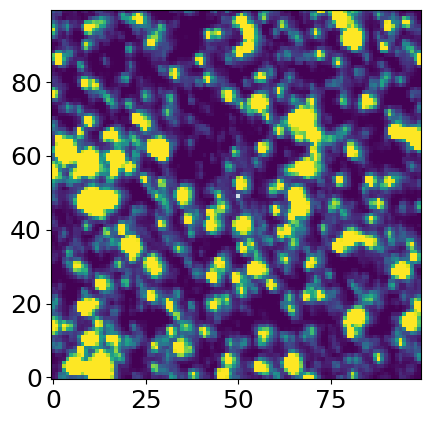

In [127]:
sn_s14.plot_cutout(show_aperture=True)
sn_s15.plot_cutout(show_aperture=True)
sn_s16.plot_cutout(show_aperture=True)

In [128]:
diff, stitched_time, stitched_lc = tess_cpm.utils.stitch_sectors(sn_s14.time, sn_s15.time, sn_s14_lc, sn_s15_lc, 100)
diff2, stitched_time2, stitched_lc2 = tess_cpm.utils.stitch_sectors(stitched_time, sn_s16.time, stitched_lc, sn_s16_lc, 100)

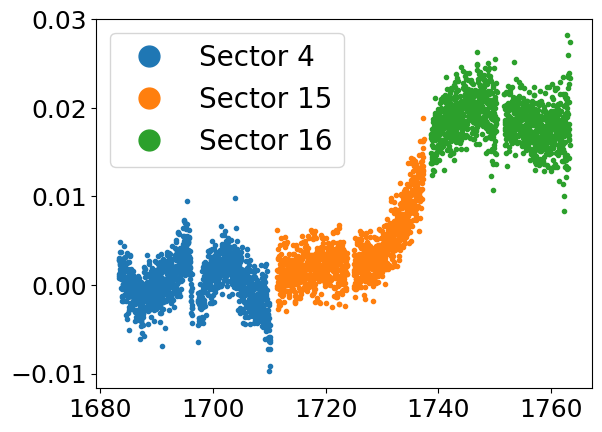

In [129]:
# plt.plot(stitched_time2, stitched_lc2, ".", c="gray", alpha=0.4)
plt.plot(sn_s14.time, sn_s14_lc, ".", c="C0", label="Sector 4")
plt.plot(sn_s15.time, sn_s15_lc+diff, ".", c="C1", label="Sector 15")
plt.plot(sn_s16.time, sn_s16_lc+diff2, ".", c="C2", label="Sector 16")
plt.legend(fontsize=20, markerscale=5)